<a href="https://colab.research.google.com/github/Gabriela2685/Accidentes/blob/main/pruebass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Cargar los datos
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSvEd0y6NK76QorUUvJjAqRZDsJRcC_rOXBFW5gDOJ4RrqkVUHR7xXbVqnnGx45Pw/pub?output=csv')

# Convertir variables categóricas en numéricas (si es necesario)
data['hora_pico'] = data['hora_pico'].map({'SI': 1, 'NO': 0})
data['horario'] = data['horario'].map({'DIA': 0, 'NOCHE': 1})
data['tipo_de_interseccion'] = data['tipo_de_interseccion'].astype('category').cat.codes
data['dia'] = data['dia'].astype('category').cat.codes
data['dia_1'] = data['dia_1'].map({'Entre semana': 0, 'Fin de semana': 1})

# Dividir los datos en entrenamiento y prueba
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Fórmula del modelo
formula = """acc ~ precipitacion + hora_pico + horario + tipo_de_interseccion + dia + dia_1"""

# Crear las matrices para el modelo
y_train, X_train = dmatrices(formula, train_data, return_type='dataframe')
y_test, X_test = dmatrices(formula, test_data, return_type='dataframe')

# Ajustar el modelo de Poisson
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

# Diagnóstico: Verificar la sobredispersión
train_data['lambda_hat'] = poisson_model.mu  # Cambiar nombre de la columna 'lambda'
train_data['aux_ols_dep'] = ((train_data['acc'] - train_data['lambda_hat'])**2 - train_data['lambda_hat']) / train_data['lambda_hat']

# Ajustar un modelo de dispersión (OLS)
ols_formula = """aux_ols_dep ~ lambda_hat - 1"""
aux_ols_model = smf.ols(ols_formula, data=train_data).fit()
print(f"Parámetro alpha para Binomial Negativa: {aux_ols_model.params[0]}")

# Ensure alpha is positive and not too small
alpha = aux_ols_model.params[0]
# If alpha is negative or very close to 0, set it to a small positive value
if alpha <= 0.01:
    alpha = 0.01  # or another small positive value
    print("Alpha adjusted to 0.01 to avoid boundary issues.")

# Ajustar el modelo de Binomial Negativa si hay sobredispersión
nb2_model = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=alpha)).fit() # Use adjusted alpha
print(nb2_model.summary())

# Hacer predicciones en el conjunto de prueba
nb2_predictions = nb2_model.get_prediction(X_test)
predictions_summary = nb2_predictions.summary_frame()

# Comparar predicciones con valores reales
predicted_counts = predictions_summary['mean']
actual_counts = y_test['acc']

# Visualizar resultados
plt.figure(figsize=(10, 6))
plt.plot(predicted_counts.values, label='Predicciones', marker='o')
plt.plot(actual_counts.values, label='Reales', marker='x')
plt.title('Accidentes Predichos vs Reales')
plt.xlabel('Índice')
plt.ylabel('Número de Accidentes')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Calcular la media y la varianza
mean_acc = data['acc'].mean()
var_acc = data['acc'].var()

print(f"Media de acc: {mean_acc}")
print(f"Varianza de acc: {var_acc}")

# Comparación
if var_acc > mean_acc:
    print("La varianza es mayor que la media: hay indicios de sobredispersión.")
else:
    print("La varianza es menor o igual a la media: no hay sobredispersión.")


In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Cargar los datos
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSvEd0y6NK76QorUUvJjAqRZDsJRcC_rOXBFW5gDOJ4RrqkVUHR7xXbVqnnGx45Pw/pub?output=csv')

# Convertir variables categóricas en numéricas
data['hora_pico'] = data['hora_pico'].map({'SI': 1, 'NO': 0})
data['horario'] = data['horario'].map({'DIA': 0, 'NOCHE': 1})
data['tipo_de_interseccion'] = data['tipo_de_interseccion'].astype('category').cat.codes
data['dia'] = data['dia'].astype('category').cat.codes
data['dia_1'] = data['dia_1'].map({'Entre semana': 0, 'Fin de semana': 1})
data['mediana'] = data['mediana'].map({'SI': 1, 'NO': 0})  # Nueva variable

# Crear interacciones adicionales
data['precip_hora_pico'] = data['precipitacion'] * data['hora_pico']
data['precip_horario'] = data['precipitacion'] * data['horario']
data['mediana_carriles'] = data['mediana'] * data['carriles']  # Nueva interacción

# Dividir los datos en entrenamiento y prueba
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Fórmula del modelo (actualizada con las nuevas variables)
formula = (
    "acc ~ precipitacion + hora_pico + horario + tipo_de_interseccion + dia + dia_1 + "
    "carriles + mediana + precip_hora_pico + precip_horario + mediana_carriles"
)

# Crear las matrices para el modelo
y_train, X_train = dmatrices(formula, train_data, return_type='dataframe')
y_test, X_test = dmatrices(formula, test_data, return_type='dataframe')

# Ajustar el modelo de Poisson
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

# Diagnóstico: Verificar la sobredispersión
train_data['lambda_hat'] = poisson_model.mu
train_data['aux_ols_dep'] = (
    (train_data['acc'] - train_data['lambda_hat'])**2 - train_data['lambda_hat']
) / train_data['lambda_hat']

# Ajustar un modelo de dispersión (OLS)
ols_formula = "aux_ols_dep ~ lambda_hat - 1"
aux_ols_model = smf.ols(ols_formula, data=train_data).fit()
print(f"Parámetro alpha para Binomial Negativa: {aux_ols_model.params[0]}")

# Asegurarse de que alpha sea positivo y no muy pequeño
alpha = max(aux_ols_model.params[0], 0.01)

# Ajustar el modelo de Binomial Negativa si hay sobredispersión
nb2_model = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
print(nb2_model.summary())

# Hacer predicciones en el conjunto de prueba
nb2_predictions = nb2_model.get_prediction(X_test)
predictions_summary = nb2_predictions.summary_frame()

# Comparar predicciones con valores reales
predicted_counts = predictions_summary['mean']
actual_counts = y_test['acc']

# Visualizar resultados
plt.figure(figsize=(10, 6))
plt.plot(predicted_counts.values, label='Predicciones', marker='o')
plt.plot(actual_counts.values, label='Reales', marker='x')
plt.title('Accidentes Predichos vs Reales')
plt.xlabel('\u00cdndice')
plt.ylabel('Número de Accidentes')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Crear el DataFrame basado en tus datos
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vR4i3H4XvouTd3J3XcXSxervyxSejeHpwEBxt9_AwJU3X0mhMfWeBYdT9tG3ZtAkA/pub?output=csv')

# Convertir la columna 'dia' a formato de fecha
data['dia'] = pd.to_datetime(data['dia'], dayfirst=True)

# Dividir los datos en entrenamiento y prueba
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Fórmula del modelo (solo incluye precipitación)
formula = "acc ~ precipitacion"

# Crear las matrices para el modelo
y_train, X_train = dmatrices(formula, train_data, return_type='dataframe')
y_test, X_test = dmatrices(formula, test_data, return_type='dataframe')

# Ajustar el modelo de Poisson
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

# Diagnóstico: Verificar la sobredispersión
train_data['lambda_hat'] = poisson_model.mu  # Valor esperado
train_data['aux_ols_dep'] = ((train_data['acc'] - train_data['lambda_hat'])**2 - train_data['lambda_hat']) / train_data['lambda_hat']

# Ajustar un modelo de dispersión (OLS)
ols_formula = """aux_ols_dep ~ lambda_hat - 1"""
aux_ols_model = smf.ols(ols_formula, data=train_data).fit()
print(f"Parámetro alpha para Binomial Negativa: {aux_ols_model.params[0]}")

# Asegurar que alpha sea positivo y razonable
alpha = max(aux_ols_model.params[0], 0.01) # Changed 'ols_model' to 'aux_ols_model'
print(f"Alpha ajustado: {alpha}")

# Ajustar el modelo de Binomial Negativa (si es necesario)
nb2_model = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
print(nb2_model.summary())

# Hacer predicciones en el conjunto de prueba
nb2_predictions = nb2_model.get_prediction(X_test)
predictions_summary = nb2_predictions.summary_frame()

# Comparar predicciones con valores reales
predicted_counts = predictions_summary['mean']
actual_counts = y_test['acc']

# Visualizar resultados
plt.figure(figsize=(10, 6))
plt.plot(predicted_counts.values, label='Predicciones', marker='o')
plt.plot(actual_counts.values, label='Reales', marker='x')
plt.title('Accidentes Predichos vs Reales')
plt.xlabel('Índice')
plt.ylabel('Número de Accidentes')
plt.legend()
plt.grid()
plt.show()


                 Generalized Linear Model Regression Results                  
Dep. Variable:                    acc   No. Observations:                  292
Model:                            GLM   Df Residuals:                      284
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -985.27
Date:                Sun, 12 Jan 2025   Deviance:                       15.501
Time:                        21:12:11   Pearson chi2:                     15.3
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9774
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.3070      0

<ipython-input-10-7f6a66fe8e1e>:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Parámetro alpha para Binomial Negativa: {aux_ols_model.params[0]}")
<ipython-input-10-7f6a66fe8e1e>:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = max(aux_ols_model.params[0], 0.01)


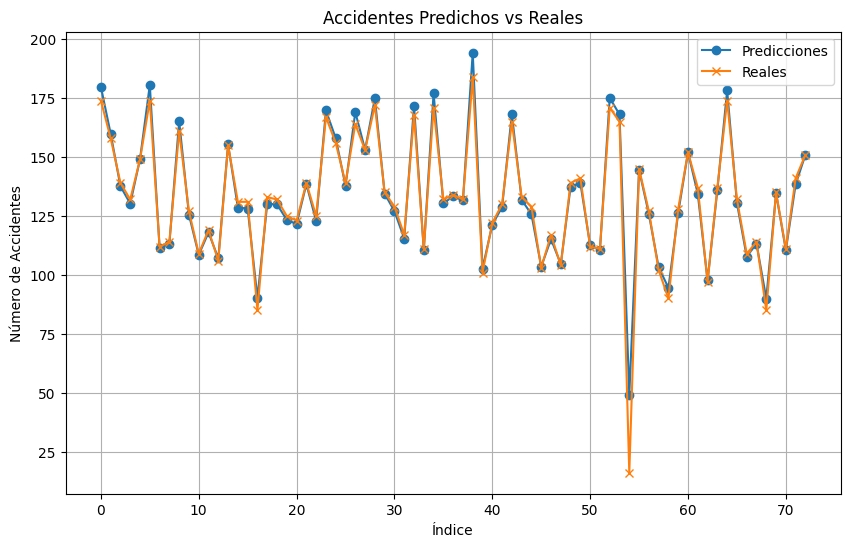

In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Cargar los datos
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vR4i3H4XvouTd3J3XcXSxervyxSejeHpwEBxt9_AwJU3X0mhMfWeBYdT9tG3ZtAkA/pub?output=csv')

# Convertir variables categóricas en numéricas (si es necesario)
data['dia_2'] = data['dia_2'].map({'Entre semana': 0, 'Fin de semana': 1})
data['dia_1'] = data['dia_1'].map({
    'lunes': 1, 'martes': 2, 'miércoles': 3, 'jueves': 4, 'viernes': 5,
    'sábado': 6, 'domingo': 7
})  # Mapear días de la semana a valores numéricos

# Dividir los datos en entrenamiento y prueba
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Fórmula del modelo
formula = ("""acc ~ np.log(TPDA_aprox) + p_no_semaforizada + p_semaforizada + dia_2 +"""
          """interseccion_Y + interseccion_T + interseccion_X"""
)

# Crear las matrices para el modelo
y_train, X_train = dmatrices(formula, train_data, return_type='dataframe')
y_test, X_test = dmatrices(formula, test_data, return_type='dataframe')

# Ajustar el modelo de Poisson
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

# Diagnóstico: Verificar la sobredispersión
train_data['lambda_hat'] = poisson_model.mu  # Predicciones ajustadas
train_data['aux_ols_dep'] = (
    (train_data['acc'] - train_data['lambda_hat'])**2 - train_data['lambda_hat']
) / train_data['lambda_hat']

# Ajustar un modelo de dispersión (OLS)
ols_formula = """aux_ols_dep ~ lambda_hat - 1"""
aux_ols_model = smf.ols(ols_formula, data=train_data).fit()
print(f"Parámetro alpha para Binomial Negativa: {aux_ols_model.params[0]}")

# Asegurarse de que alpha sea positivo
alpha = max(aux_ols_model.params[0], 0.01)

# Ajustar el modelo de Binomial Negativa si hay sobredispersión
nb2_model = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
print(nb2_model.summary())

# Hacer predicciones en el conjunto de prueba
nb2_predictions = nb2_model.get_prediction(X_test)
predictions_summary = nb2_predictions.summary_frame()

# Comparar predicciones con valores reales
predicted_counts = predictions_summary['mean']
actual_counts = y_test['acc']

# Visualizar resultados
plt.figure(figsize=(10, 6))
plt.plot(predicted_counts.values, label='Predicciones', marker='o')
plt.plot(actual_counts.values, label='Reales', marker='x')
plt.title('Accidentes Predichos vs Reales')
plt.xlabel('Índice')
plt.ylabel('Número de Accidentes')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Cargar los datos
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vR4i3H4XvouTd3J3XcXSxervyxSejeHpwEBxt9_AwJU3X0mhMfWeBYdT9tG3ZtAkA/pub?output=csv')

# Filtrar valores negativos o nulos en TPDA
data = data[data['TPDA_aprox'] > 0]

# Convertir variables categóricas en numéricas (si es necesario)
data['dia_2'] = data['dia_2'].map({'Entre semana': 0, 'Fin de semana': 1})
data['dia_1'] = data['dia_1'].map({
    'lunes': 1, 'martes': 2, 'miércoles': 3, 'jueves': 4, 'viernes': 5,
    'sábado': 6, 'domingo': 7
})

# Dividir los datos en entrenamiento y prueba
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Fórmula del modelo
formula = ("""acc ~ np.log(TPDA_aprox) + p_no_semaforizada + p_semaforizada + dia_2 +"""
           """interseccion_Y + interseccion_T + interseccion_X + LV_40 + LV_50 + LV_80"""
)

# Crear las matrices para el modelo
y_train, X_train = dmatrices(formula, train_data, return_type='dataframe')
y_test, X_test = dmatrices(formula, test_data, return_type='dataframe')

# Evaluar multicolinealidad (VIF)
vif_data = pd.DataFrame()
vif_data["Variable"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print(vif_data)

# Ajustar el modelo de Poisson
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

# Verificar sobredispersión
train_data['lambda_hat'] = poisson_model.mu  # Predicciones ajustadas
train_data['aux_ols_dep'] = (
    (train_data['acc'] - train_data['lambda_hat'])**2 - train_data['lambda_hat']
) / train_data['lambda_hat']

# Ajustar un modelo de dispersión (OLS)
ols_formula = """aux_ols_dep ~ lambda_hat - 1"""
aux_ols_model = smf.ols(ols_formula, data=train_data).fit()
print(f"Parámetro alpha para Binomial Negativa: {aux_ols_model.params[0]}")

# Evaluar residuos del modelo
train_data['resid_pearson'] = (train_data['acc'] - poisson_model.mu) / np.sqrt(poisson_model.mu)

# Graficar residuos
plt.figure(figsize=(10, 6))
plt.scatter(poisson_model.mu, train_data['resid_pearson'], alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuos de Pearson vs Predicciones Ajustadas')
plt.xlabel('Predicciones Ajustadas')
plt.ylabel('Residuos de Pearson')
plt.grid()
plt.show()


In [ ]:
plt.hist(train_data['resid_pearson'], bins=30, edgecolor='k')
plt.title('Distribución de Residuos de Pearson')
plt.xlabel('Residuos de Pearson')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()


VIF para cada variable:
              Variable          VIF
0           Intercept  7895.215217
1  np.log(TPDA_aprox)     6.516213
2   p_no_semaforizada     5.027324
3      p_semaforizada     4.777296
4               dia_2     1.086713
5      interseccion_Y     1.121358
6      interseccion_T     1.271893
7      interseccion_X     2.575813
8             festivo     1.036586
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    acc   No. Observations:                  292
Model:                            GLM   Df Residuals:                      283
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -985.25
Date:                Sun, 12 Jan 2025   Deviance:                       15.461
Time:                        22:17:14   Pearson chi2:                   

<ipython-input-24-b09d1e66e910>:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Parámetro alpha para Binomial Negativa: {aux_ols_model.params[0]}")
<ipython-input-24-b09d1e66e910>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = max(aux_ols_model.params[0], 0.01)


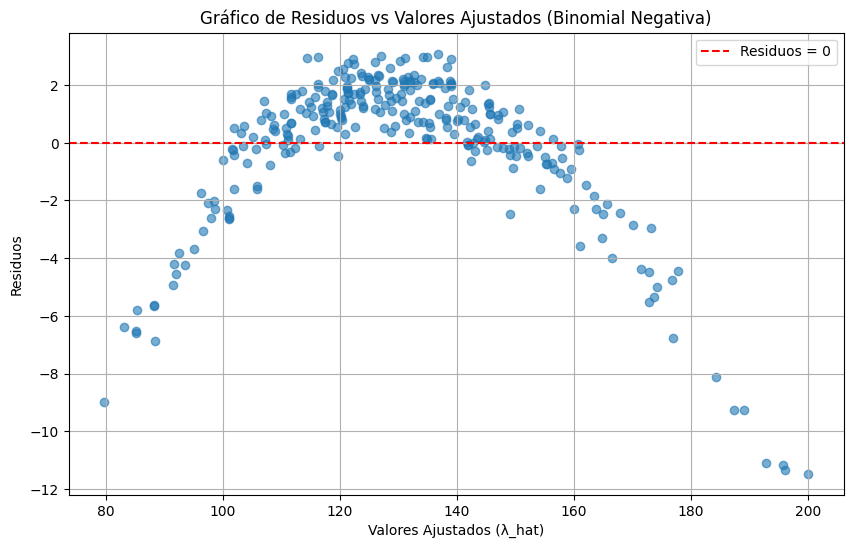

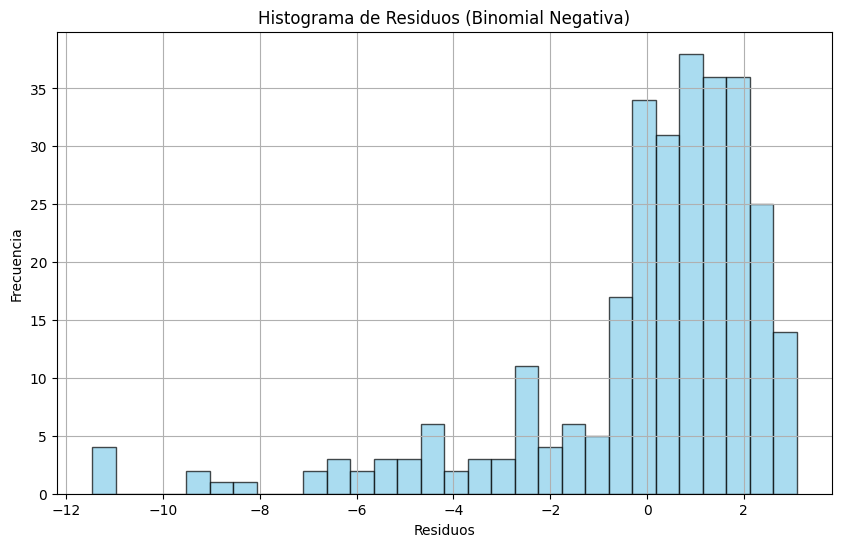

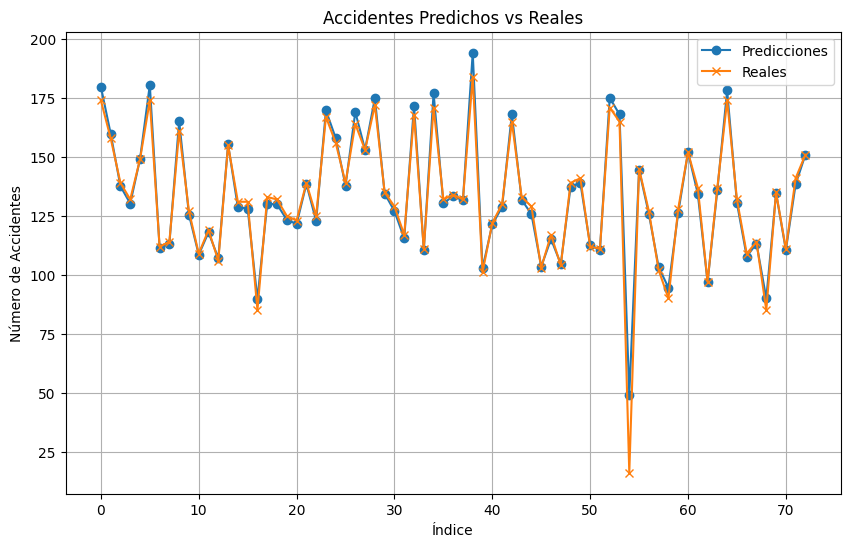

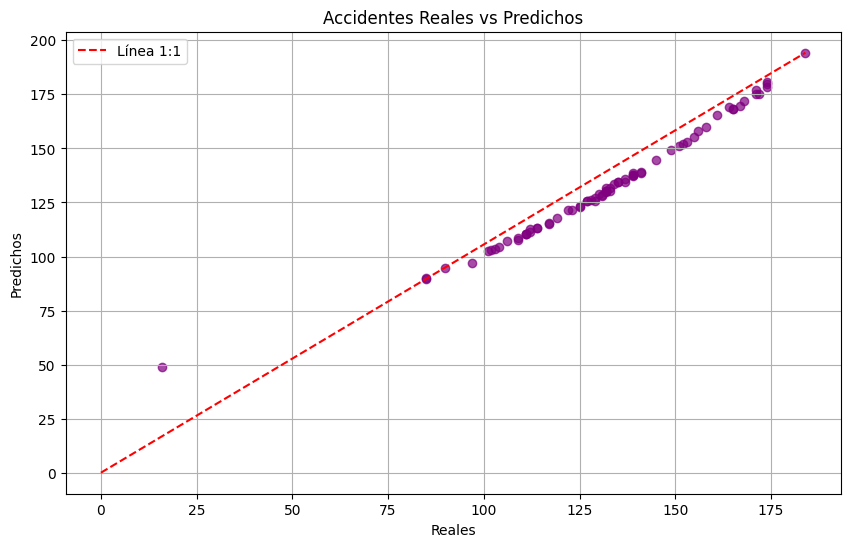

In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Cargar los datos
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vR4i3H4XvouTd3J3XcXSxervyxSejeHpwEBxt9_AwJU3X0mhMfWeBYdT9tG3ZtAkA/pub?output=csv')

# Convertir variables categóricas en numéricas (si es necesario)
data['dia_2'] = data['dia_2'].map({'Entre semana': 0, 'Fin de semana': 1})
data['dia_1'] = data['dia_1'].map({
    'lunes': 1, 'martes': 2, 'miércoles': 3, 'jueves': 4, 'viernes': 5,
    'sábado': 6, 'domingo': 7
})  # Mapear días de la semana a valores numéricos
data['festivo'] = data['festivo'].map({'SI': 1, 'NO': 0})

# Dividir los datos en entrenamiento y prueba
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Fórmula del modelo
formula = ("""acc ~ np.log(TPDA_aprox) + p_no_semaforizada + p_semaforizada + dia_2 +"""
          """interseccion_Y + interseccion_T + interseccion_X + festivo"""
)

# Crear las matrices para el modelo
y_train, X_train = dmatrices(formula, train_data, return_type='dataframe')
y_test, X_test = dmatrices(formula, test_data, return_type='dataframe')

# Calcular el VIF (Multicolinealidad)
vif_data = pd.DataFrame()
vif_data["Variable"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print("VIF para cada variable:\n", vif_data)

# Ajustar el modelo de Poisson
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

# Diagnóstico: Verificar la sobredispersión
train_data['lambda_hat'] = poisson_model.mu  # Predicciones ajustadas
train_data['aux_ols_dep'] = (
    (train_data['acc'] - train_data['lambda_hat'])**2 - train_data['lambda_hat']
) / train_data['lambda_hat']

# Ajustar un modelo de dispersión (OLS)
ols_formula = """aux_ols_dep ~ lambda_hat - 1"""
aux_ols_model = smf.ols(ols_formula, data=train_data).fit()
print(f"Parámetro alpha para Binomial Negativa: {aux_ols_model.params[0]}")

# Asegurarse de que alpha sea positivo
alpha = max(aux_ols_model.params[0], 0.01)

# Ajustar el modelo de Binomial Negativa si hay sobredispersión
nb2_model = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
print(nb2_model.summary())

# Evaluación de residuos del modelo de Binomial Negativa
train_data['residuos'] = nb2_model.resid_response
plt.figure(figsize=(10, 6))
plt.scatter(train_data['lambda_hat'], train_data['residuos'], alpha=0.6)
plt.axhline(0, color='red', linestyle='--', label='Residuos = 0')
plt.title('Gráfico de Residuos vs Valores Ajustados (Binomial Negativa)')
plt.xlabel('Valores Ajustados (λ_hat)')
plt.ylabel('Residuos')
plt.legend()
plt.grid()
plt.show()

# Histograma de residuos
plt.figure(figsize=(10, 6))
plt.hist(train_data['residuos'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histograma de Residuos (Binomial Negativa)')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

# Hacer predicciones en el conjunto de prueba
nb2_predictions = nb2_model.get_prediction(X_test)
predictions_summary = nb2_predictions.summary_frame()

# Comparar predicciones con valores reales
predicted_counts = predictions_summary['mean']
actual_counts = y_test['acc']

# Visualizar resultados: Predicciones vs Reales
plt.figure(figsize=(10, 6))
plt.plot(predicted_counts.values, label='Predicciones', marker='o')
plt.plot(actual_counts.values, label='Reales', marker='x')
plt.title('Accidentes Predichos vs Reales')
plt.xlabel('Índice')
plt.ylabel('Número de Accidentes')
plt.legend()
plt.grid()
plt.show()

# Gráfico de dispersión: Valores reales vs Predichos
plt.figure(figsize=(10, 6))
plt.scatter(actual_counts, predicted_counts, alpha=0.7, color='purple')
plt.plot([0, max(actual_counts)], [0, max(predicted_counts)], color='red', linestyle='--', label='Línea 1:1')
plt.title('Accidentes Reales vs Predichos')
plt.xlabel('Reales')
plt.ylabel('Predichos')
plt.legend()
plt.grid()
plt.show()


VIF para cada variable:
              Variable          VIF
0           Intercept  7848.453942
1  np.log(TPDA_aprox)     6.487379
2   p_no_semaforizada     4.978705
3      p_semaforizada     4.765536
4               dia_2     1.085793
5      interseccion_Y     1.116097
6      interseccion_T     1.270645
7      interseccion_X     2.562221
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    acc   No. Observations:                  292
Model:                            GLM   Df Residuals:                      284
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -985.27
Date:                Mon, 13 Jan 2025   Deviance:                       15.501
Time:                        06:34:26   Pearson chi2:                     15.3
No. Iterations:             

<ipython-input-1-4749d6c97efb>:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Parámetro alpha para Binomial Negativa: {aux_ols_model.params[0]}")
<ipython-input-1-4749d6c97efb>:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = max(aux_ols_model.params[0], 0.01)


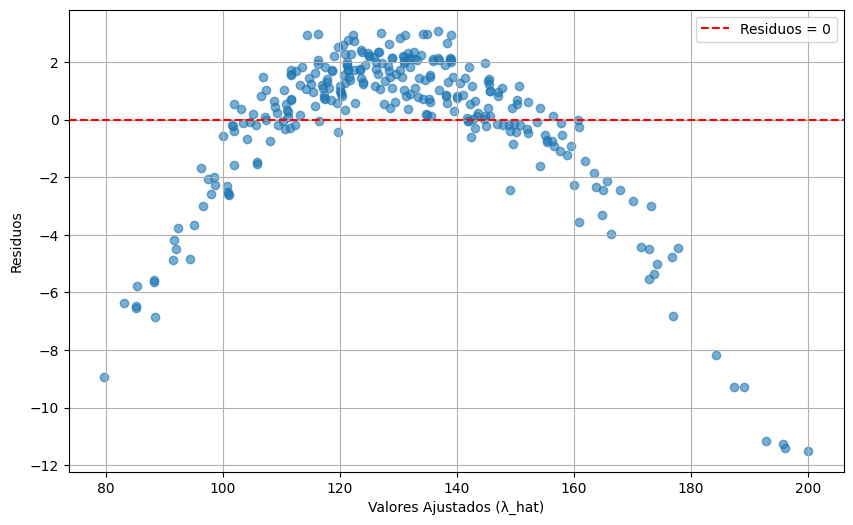

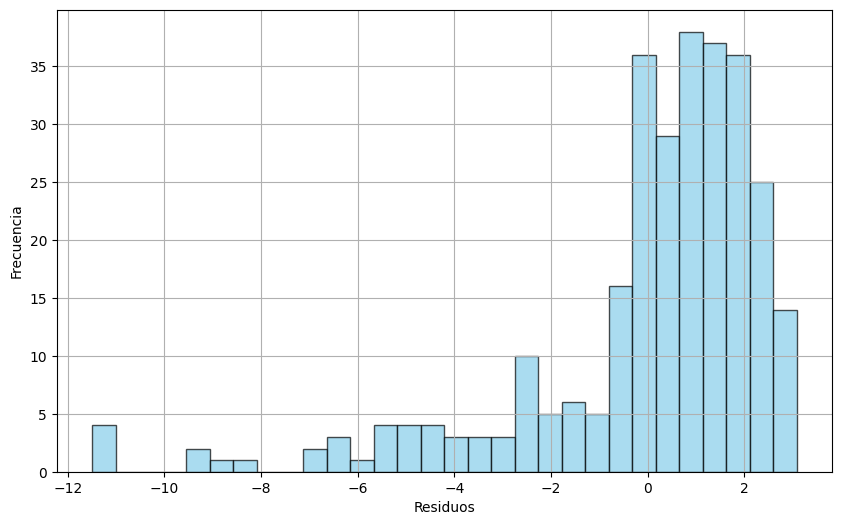

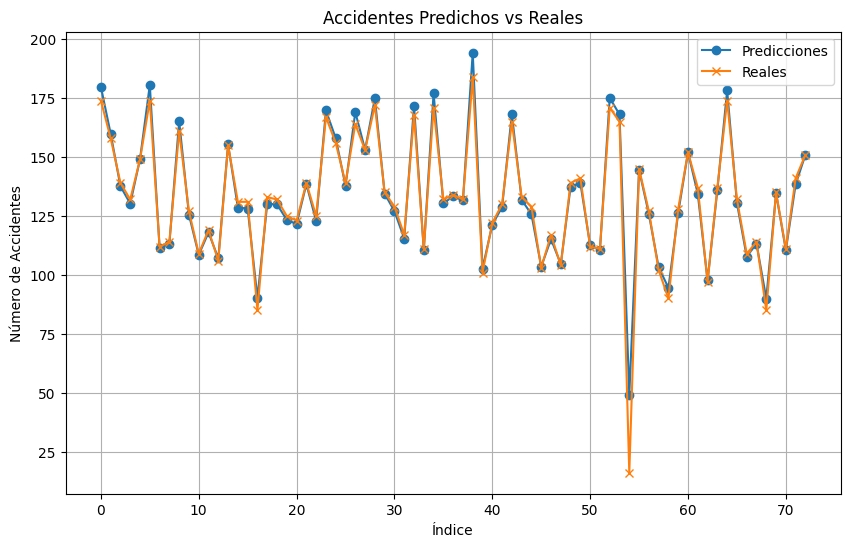

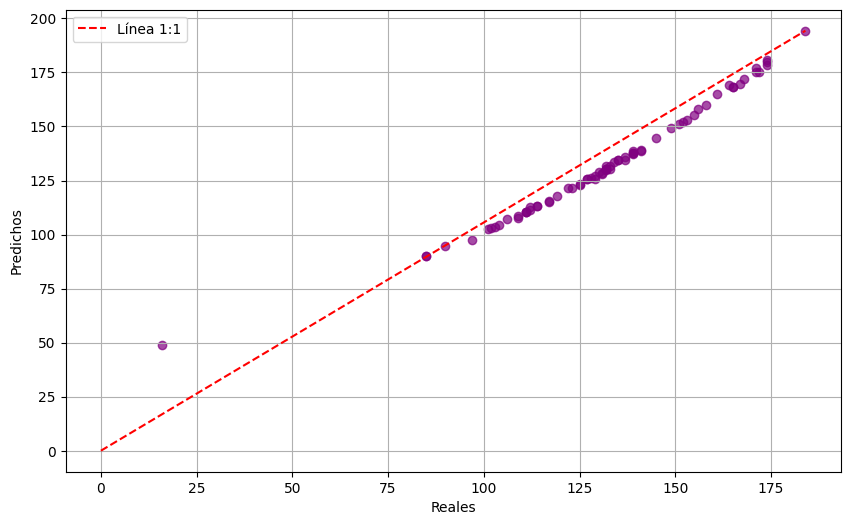

In [ ]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Cargar los datos
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vR4i3H4XvouTd3J3XcXSxervyxSejeHpwEBxt9_AwJU3X0mhMfWeBYdT9tG3ZtAkA/pub?output=csv')

# Convertir variables categóricas en numéricas (si es necesario)
data['dia_2'] = data['dia_2'].map({'Entre semana': 0, 'Fin de semana': 1})
data['dia_1'] = data['dia_1'].map({
    'lunes': 1, 'martes': 2, 'miércoles': 3, 'jueves': 4, 'viernes': 5,
    'sábado': 6, 'domingo': 7
})  # Mapear días de la semana a valores numéricos
data['festivo'] = data['festivo'].map({'SI': 1, 'NO': 0})

# Dividir los datos en entrenamiento y prueba
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Fórmula del modelo
formula = ("""acc ~ np.log(TPDA_aprox) + p_no_semaforizada + p_semaforizada + dia_2 +"""
          """interseccion_Y + interseccion_T + interseccion_X"""
)

# Crear las matrices para el modelo
y_train, X_train = dmatrices(formula, train_data, return_type='dataframe')
y_test, X_test = dmatrices(formula, test_data, return_type='dataframe')

# Calcular el VIF (Multicolinealidad)
vif_data = pd.DataFrame()
vif_data["Variable"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print("VIF para cada variable:\n", vif_data)

# Ajustar el modelo de Poisson
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

# Diagnóstico: Verificar la sobredispersión
train_data['lambda_hat'] = poisson_model.mu  # Predicciones ajustadas
train_data['aux_ols_dep'] = (
    (train_data['acc'] - train_data['lambda_hat'])**2 - train_data['lambda_hat']
) / train_data['lambda_hat']

# Ajustar un modelo de dispersión (OLS)
ols_formula = """aux_ols_dep ~ lambda_hat - 1"""
aux_ols_model = smf.ols(ols_formula, data=train_data).fit()
print(f"Parámetro alpha para Binomial Negativa: {aux_ols_model.params[0]}")

# Asegurarse de que alpha sea positivo
alpha = max(aux_ols_model.params[0], 0.01)

# Ajustar el modelo de Binomial Negativa si hay sobredispersión
nb2_model = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial(alpha=alpha)).fit()
print(nb2_model.summary())

# Evaluación de residuos del modelo de Binomial Negativa
train_data['residuos'] = nb2_model.resid_response
plt.figure(figsize=(10, 6))
plt.scatter(train_data['lambda_hat'], train_data['residuos'], alpha=0.6)
plt.axhline(0, color='red', linestyle='--', label='Residuos = 0')
#plt.title('Gráfico de Residuos vs Valores Ajustados (Binomial Negativa)')
plt.xlabel('Valores Ajustados (λ_hat)')
plt.ylabel('Residuos')
plt.legend()
plt.grid()
plt.show()

# Histograma de residuos
plt.figure(figsize=(10, 6))
plt.hist(train_data['residuos'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
#plt.title('Histograma de Residuos (Binomial Negativa)')
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

# Hacer predicciones en el conjunto de prueba
nb2_predictions = nb2_model.get_prediction(X_test)
predictions_summary = nb2_predictions.summary_frame()

# Comparar predicciones con valores reales
predicted_counts = predictions_summary['mean']
actual_counts = y_test['acc']

# Visualizar resultados: Predicciones vs Reales
plt.figure(figsize=(10, 6))
plt.plot(predicted_counts.values, label='Predicciones', marker='o')
plt.plot(actual_counts.values, label='Reales', marker='x')
plt.title('Accidentes Predichos vs Reales')
plt.xlabel('Índice')
plt.ylabel('Número de Accidentes')
plt.legend()
plt.grid()
plt.show()

# Gráfico de dispersión: Valores reales vs Predichos
plt.figure(figsize=(10, 6))
plt.scatter(actual_counts, predicted_counts, alpha=0.7, color='purple')
plt.plot([0, max(actual_counts)], [0, max(predicted_counts)], color='red', linestyle='--', label='Línea 1:1')
#plt.title('Accidentes Reales vs Predichos')
plt.xlabel('Reales')
plt.ylabel('Predichos')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import sys
print(sys.version)

3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
